Note: All of the text contains here are not purely wirtten by me, i got help by AI and other refrences to make me understand this topic better.

Arieldhipta Tarliman - 2702234636

https://www.kaggle.com/code/banddaniel/brain-tumor-segmentation-detectron2-map-50-76-2

On that dataset contains a json file that define if the images has a tumor (class 1) or not (class 0) (from the iamge description) by the annotation part of that json. if the images contains in the annotation part then it has a tumor

In [ ]:
import json
import os
import matplotlib.patches as patches
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def check_tumor(path_to_json):
    image_ids_with_tumors = set()

    with open(path_to_json, 'r') as f:
        data = json.load(f)

    if 'annotations' not in data:
        raise KeyError("The JSON file does not contain an 'annotations' key")

    for annotation in data['annotations']:
        if 'image_id' in annotation:
            image_ids_with_tumors.add(annotation['image_id'])
        else:
            print(f"Warning: Annotation missing 'image_id': {annotation}")
    print(f"Found {len(image_ids_with_tumors)} unique image IDs with tumors")

In [12]:
check_tumor('train/_annotations.coco.json')

Found 1501 unique image IDs with tumors


In [15]:
check_tumor('valid/_annotations.coco.json')

Found 429 unique image IDs with tumors


In [13]:
check_tumor('test/_annotations.coco.json')

Found 215 unique image IDs with tumors


In [ ]:
with open('train/_annotations.coco.json', 'r') as f:
    data = json.load(f)
categories = data['categories']
images = data['images']
annotations = data['annotations']
num_images = len(images)
num_annotations = len(annotations)
print(f"Dataset Overview:")
print(f"Total Images: {num_images}")
print(f"Total Annotations: {num_annotations}")
print(f"Categories: {[cat['name'] for cat in categories]}")

Dataset Overview:
Total Images: 1502
Total Annotations: 1502
Categories: ['Tumor', '0', '1']


In [ ]:
category_counts = {1: 0, 2: 0} 
for ann in annotations:
    category_counts[ann['category_id']] += 1

print("\nCategory Distribution:")
print(f"Category 1 (0): {category_counts[1]} annotations")
print(f"Category 2 (1): {category_counts[2]} annotations")


Category Distribution:
Category 1 (0): 771 annotations
Category 2 (1): 731 annotations


In [ ]:
image_annotation_counts = {}
for img in images:
    image_annotation_counts[img['id']] = 0
for ann in annotations:
    image_annotation_counts[ann['image_id']] += 1

annotations_per_image = list(image_annotation_counts.values())
unique_counts = np.unique(annotations_per_image, return_counts=True)
print("\nAnnotations per Image:")
for count, freq in zip(unique_counts[0], unique_counts[1]):
    print(f"Images with {count} annotation(s): {freq}")


Annotations per Image:
Images with 0 annotation(s): 1
Images with 1 annotation(s): 1500
Images with 2 annotation(s): 1


I dont even know what is the diffrent between tehs e images with annotations, does that mean the images with 0 annotations are not having any tumor lets check it out

Loading annotations from: train/_annotations.coco.json

Found example files:
-> 0 annotations: 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg
-> 1 annotation:  2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg
-> 2 annotations: 176_jpg.rf.23ef40c30986ba54b865d55a934bfa72.jpg
------------------------------


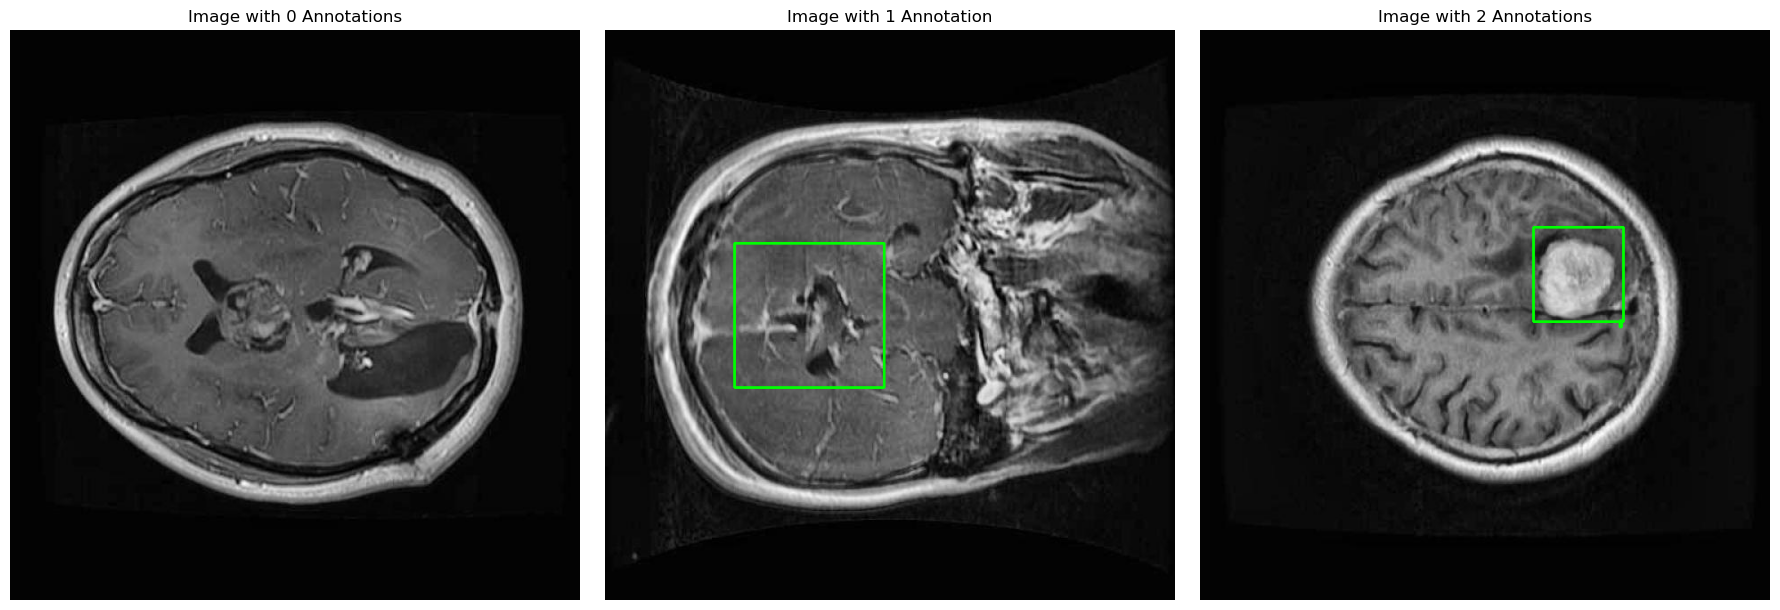

In [ ]:

ANNOTATION_FILE = 'train/_annotations.coco.json'
IMAGE_DIR = 'train/'

def plot_simple_examples():
    """
    Finds and plots one example each for images with 0, 1, and 2
    annotations, drawing a simple bounding box.
    """
    print(f"Loading annotations from: {ANNOTATION_FILE}")
    with open(ANNOTATION_FILE, 'r') as f:
        coco_data = json.load(f)

    image_counts = {}
    for img in coco_data['images']:
        image_counts[img['id']] = 0
    for ann in coco_data['annotations']:
        if ann['image_id'] in image_counts:
            image_counts[ann['image_id']] += 1

    example_ids = {
        'zero_ann': None,
        'one_ann': None,
        'two_ann': None
    }
    for img_id, count in image_counts.items():
        if count == 0 and example_ids['zero_ann'] is None:
            example_ids['zero_ann'] = img_id
        elif count == 1 and example_ids['one_ann'] is None:
            example_ids['one_ann'] = img_id
        elif count == 2 and example_ids['two_ann'] is None:
            example_ids['two_ann'] = img_id

    id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
    print("\nFound example files:")
    if example_ids['zero_ann'] is not None:
        print(f"-> 0 annotations: {id_to_filename[example_ids['zero_ann']]}")
    if example_ids['one_ann'] is not None:
        print(f"-> 1 annotation:  {id_to_filename[example_ids['one_ann']]}")
    if example_ids['two_ann'] is not None:
        print(f"-> 2 annotations: {id_to_filename[example_ids['two_ann']]}")
    print("-" * 30)
    
    id_to_annotations = {img['id']: [] for img in coco_data['images']}
    for ann in coco_data['annotations']:
        if ann['image_id'] in id_to_annotations:
            id_to_annotations[ann['image_id']].append(ann)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    img_id_0 = example_ids['zero_ann']
    if img_id_0 is not None:
        img_path_0 = os.path.join(IMAGE_DIR, id_to_filename[img_id_0])
        image_0 = cv2.imread(img_path_0)
        axes[0].imshow(cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Image with 0 Annotations")
    axes[0].axis('off')

    img_id_1 = example_ids['one_ann']
    if img_id_1 is not None:
        img_path_1 = os.path.join(IMAGE_DIR, id_to_filename[img_id_1])
        image_1 = cv2.imread(img_path_1)
        for ann in id_to_annotations[img_id_1]:
            x, y, w, h = ann['bbox']
            pt1 = (int(x), int(y))
            pt2 = (int(x + w), int(y + h))
            cv2.rectangle(image_1, pt1, pt2, color=(0, 255, 0), thickness=2)
        axes[1].imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Image with 1 Annotation")
    axes[1].axis('off')

    img_id_2 = example_ids['two_ann']
    if img_id_2 is not None:
        img_path_2 = os.path.join(IMAGE_DIR, id_to_filename[img_id_2])
        image_2 = cv2.imread(img_path_2)
        for ann in id_to_annotations[img_id_2]:
            x, y, w, h = ann['bbox']
            pt1 = (int(x), int(y))
            pt2 = (int(x + w), int(y + h))
            cv2.rectangle(image_2, pt1, pt2, color=(0, 255, 0), thickness=2)
        axes[2].imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Image with 2 Annotations")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    plot_simple_examples()

It seems liek the annotation ID for the images are skipped, so there are no bounding box even though you can still where the tumor is located at.

In [ ]:
areas = []
widths = []
heights = []
x_mins = []
y_mins = []
category_areas = {1: [], 2: []}
category_x_mins = {1: [], 2: []}
category_y_mins = {1: [], 2: []}

for ann in annotations:
    bbox = ann['bbox'] 
    area = ann['area']
    category_id = ann['category_id']
    
    areas.append(area)
    widths.append(bbox[2])
    heights.append(bbox[3])
    x_mins.append(bbox[0])
    y_mins.append(bbox[1])
    
    category_areas[category_id].append(area)
    category_x_mins[category_id].append(bbox[0])
    category_y_mins[category_id].append(bbox[1])

print("\nBounding Box Area Distribution:")
print(f"Min Area: {min(areas):.3f} pixels²")
print(f"Max Area: {max(areas):.3f} pixels²")
print(f"Mean Area: {np.mean(areas):.3f} pixels²")
print(f"Median Area: {np.median(areas):.3f} pixels²")
print(f"Std Area: {np.std(areas):.3f} pixels²")

print("\nBounding Box Width Distribution:")
print(f"Min Width: {min(widths):.3f} pixels")
print(f"Max Width: {max(widths):.3f} pixels")
print(f"Mean Width: {np.mean(widths):.3f} pixels")

print("\nBounding Box Height Distribution:")
print(f"Min Height: {min(heights):.3f} pixels")
print(f"Max Height: {max(heights):.3f} pixels")
print(f"Mean Height: {np.mean(heights):.3f} pixels")

print("\nSpatial Distribution (x_min):")
print(f"Min x_min: {min(x_mins):.3f} pixels")
print(f"Max x_min: {max(x_mins):.3f} pixels")
print(f"Mean x_min: {np.mean(x_mins):.3f} pixels")

print("\nSpatial Distribution (y_min):")
print(f"Min y_min: {min(y_mins):.3f} pixels")
print(f"Max y_min: {max(y_mins):.3f} pixels")
print(f"Mean y_min: {np.mean(y_mins):.3f} pixels")


Bounding Box Area Distribution:
Min Area: 18.750 pixels²
Max Area: 128562.500 pixels²
Mean Area: 14964.761 pixels²
Median Area: 12025.000 pixels²
Std Area: 10980.217 pixels²

Bounding Box Width Distribution:
Min Width: 2.500 pixels
Max Width: 372.500 pixels
Mean Width: 116.491 pixels

Bounding Box Height Distribution:
Min Height: 7.500 pixels
Max Height: 467.500 pixels
Mean Height: 116.026 pixels

Spatial Distribution (x_min):
Min x_min: 49.000 pixels
Max x_min: 471.000 pixels
Mean x_min: 247.168 pixels

Spatial Distribution (y_min):
Min y_min: 105.000 pixels
Max y_min: 440.000 pixels
Mean y_min: 260.395 pixels


In [ ]:
for cat_id in [1, 2]:
    print(f"\nCategory {cat_id} (Name: {categories[cat_id]['name']}):")
    print(f"Mean Area: {np.mean(category_areas[cat_id]):.3f} pixels²")
    print(f"Mean x_min: {np.mean(category_x_mins[cat_id]):.3f} pixels")
    print(f"Mean y_min: {np.mean(category_y_mins[cat_id]):.3f} pixels")


Category 1 (Name: 0):
Mean Area: 19418.024 pixels²
Mean x_min: 214.157 pixels
Mean y_min: 266.837 pixels

Category 2 (Name: 1):
Mean Area: 10267.818 pixels²
Mean x_min: 281.985 pixels
Mean y_min: 253.602 pixels


In [ ]:
image_to_annotations = {}
for ann in annotations:
    image_id = ann['image_id']
    if image_id not in image_to_annotations:
        image_to_annotations[image_id] = []
    image_to_annotations[image_id].append(ann)

print("Checking Segmentation Rectangularity:")
for ann in annotations[:5]:
    bbox = ann['bbox'] 
    seg = ann['segmentation'][0]
    expected_seg = [
        bbox[0] + bbox[2], bbox[1], 
        bbox[0], bbox[1],           
        bbox[0], bbox[1] + bbox[3], 
        bbox[0] + bbox[2], bbox[1] + bbox[3], 
        bbox[0] + bbox[2], bbox[1]  
    ]

    is_rectangular = all(abs(seg[i] - expected_seg[i]) < 1.0 for i in range(len(seg)))
    print(f"Annotation ID {ann['id']}: Segmentation is rectangular: {is_rectangular}")
    if not is_rectangular:
        print(f"  Actual Segmentation: {seg}")
        print(f"  Expected Segmentation: {expected_seg}")

Checking Segmentation Rectangularity:
Annotation ID 0: Segmentation is rectangular: True
Annotation ID 1: Segmentation is rectangular: True
Annotation ID 2: Segmentation is rectangular: True
Annotation ID 3: Segmentation is rectangular: True
Annotation ID 4: Segmentation is rectangular: True


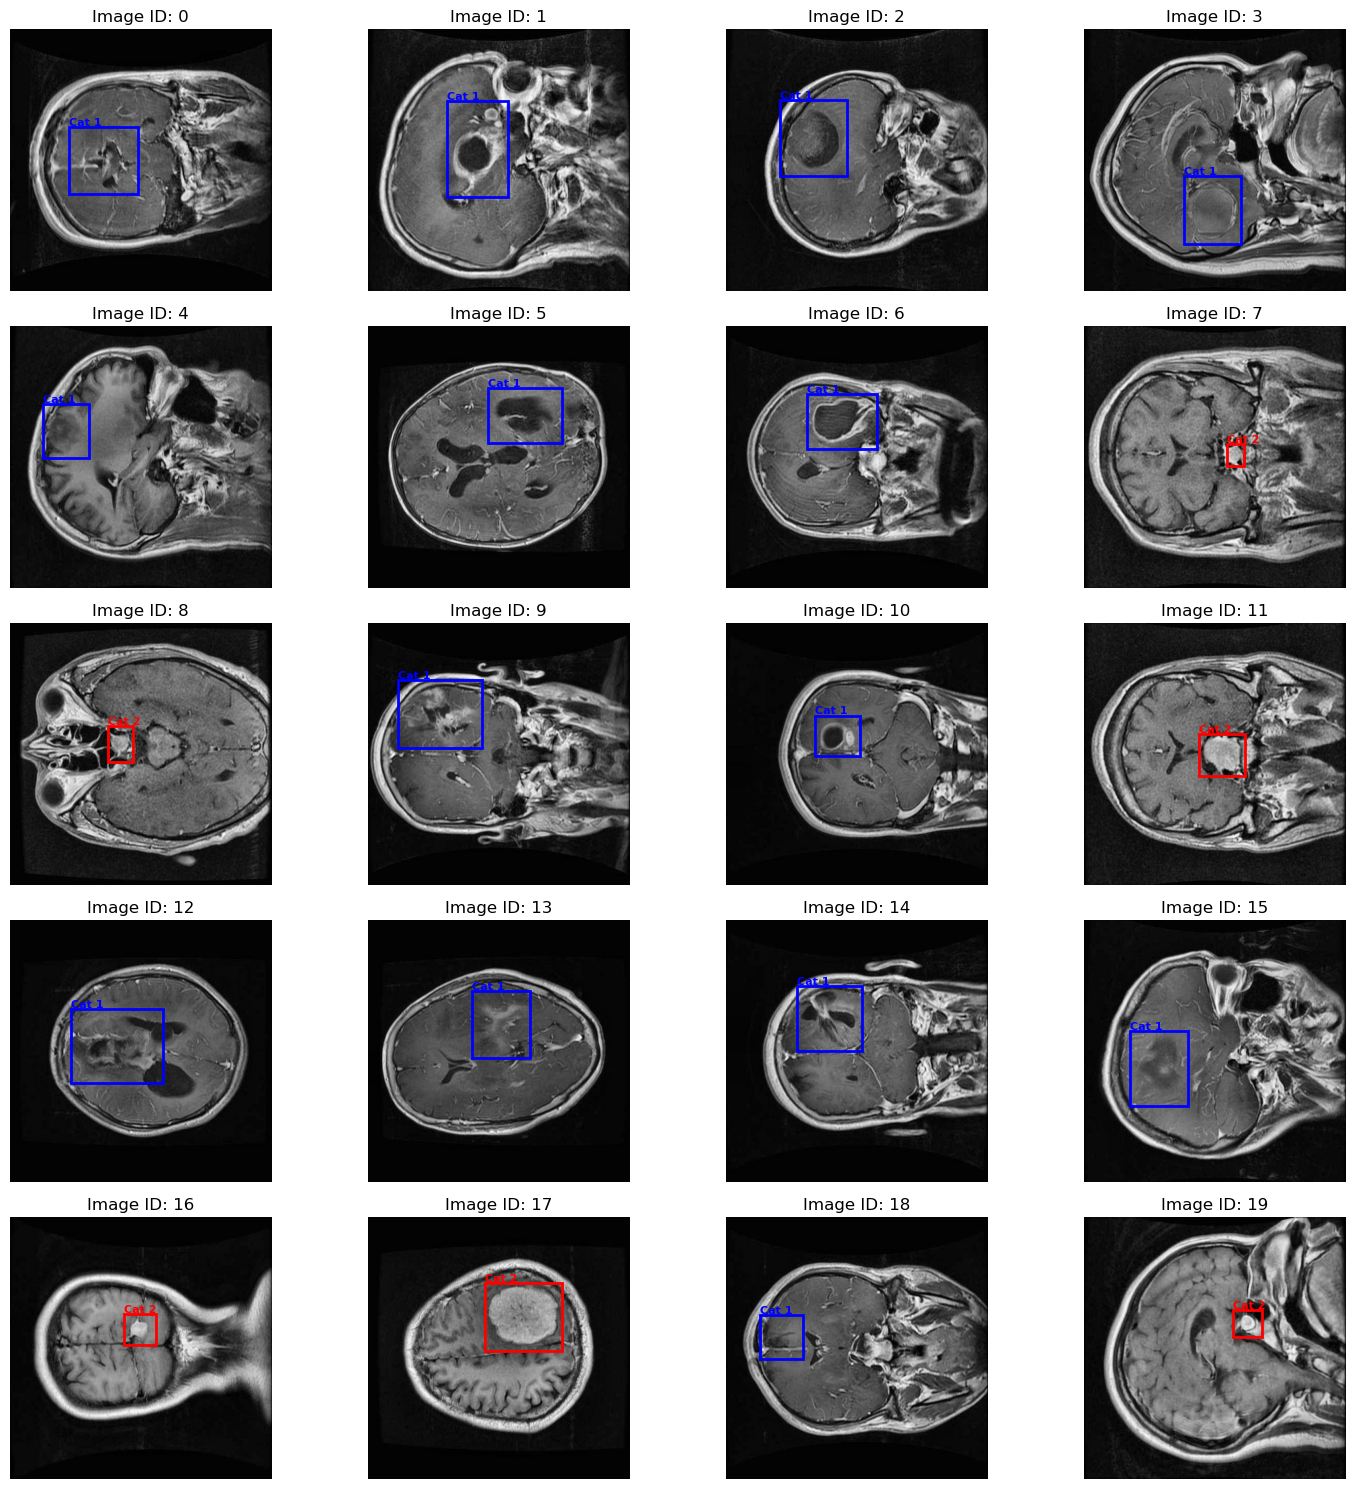

In [ ]:
num_images_to_plot = 20
rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()
image_dir = "./train"  
for idx, img_info in enumerate(images[:num_images_to_plot]):
    image_id = img_info['id']
    file_name = img_info['file_name']
    image_path = os.path.join(image_dir, file_name)
    
    try:
        img = Image.open(image_path)
        img = np.array(img)
        
        axes[idx].imshow(img)
        axes[idx].set_title(f"Image ID: {image_id}")
        
        if image_id in image_to_annotations:
            for ann in image_to_annotations[image_id]:
                bbox = ann['bbox']
                category_id = ann['category_id']
                color = 'blue' if category_id == 1 else 'red'
                rect = patches.Rectangle(
                    (bbox[0], bbox[1]), bbox[2], bbox[3],
                    linewidth=2, edgecolor=color, facecolor='none'
                )
                axes[idx].add_patch(rect)
                axes[idx].text(
                    bbox[0], bbox[1] - 5, f"Cat {category_id}",
                    color=color, fontsize=8, weight='bold'
                )
        else:
            print(f"No annotations for Image ID: {image_id}")
        
        axes[idx].axis('off')
        
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
        axes[idx].text(0.5, 0.5, f"Image {file_name}\nNot Found",
                       ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].axis('off')
for idx in range(len(images[:num_images_to_plot]), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

It seems that the blue bounding box(cat1) is harder to identify visually by human eyes than teh red one(cat2). It shows that cat 1 type of tumor is more darker then cat 2 type of tumor

# Modelling

In [ ]:
class BrainTumorDataset(Dataset):
    """
    It reads COCO-style JSON annotations to generate binary segmentation masks.
    """
    def __init__(self, image_dir, json_path, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            json_path (string): Path to the COCO-style JSON file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        
        with open(json_path, 'r') as f:
            self.coco_data = json.load(f)
            
        self.images = self.coco_data['images']
        self.annotations = self.coco_data['annotations']
        
        self.image_id_to_annotations = {}
        for ann in self.annotations:
            image_id = ann['image_id']
            if image_id not in self.image_id_to_annotations:
                self.image_id_to_annotations[image_id] = []
            self.image_id_to_annotations[image_id].append(ann)
            
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = self.images[idx]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        
        # Load image
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file not found at {image_path}. Skipping.")
            # Return a dummy sample if file not found
            return torch.zeros(3, 256, 256), torch.zeros(1, 256, 256)

        # Create segmentation mask from annotations
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        
        if image_info['id'] in self.image_id_to_annotations:
            annotations = self.image_id_to_annotations[image_info['id']]
            for ann in annotations:
                # The segmentation is a list of polygons
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape(-1, 2)
                    # Use PIL to draw the polygon on the mask
                    mask_img = Image.fromarray(mask)
                    draw = ImageDraw.Draw(mask_img)
                    # The polygon is given as [x1, y1, x2, y2, ...]. PIL needs a list of tuples [(x1,y1), (x2,y2), ...]
                    draw.polygon([tuple(p) for p in poly], outline=1, fill=1)
                    mask = np.array(mask_img)

        mask = Image.fromarray(mask)

        # Apply transformations
        if self.transform:
            # We need to apply the same random transformations to both image and mask
            # A common way is to get the state of the random number generator
            state = torch.get_rng_state()
            image = self.transform(image)
            torch.set_rng_state(state)
            mask = self.transform(mask)

        # Ensure mask is a binary tensor with a channel dimension
        mask = (mask > 0).float()
        
        return image, mask

# U-Net Model Architecture
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Loss Function and Evaluation Metric

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply sigmoid to logits to get probabilities
        probs = torch.sigmoid(logits)
        
        # Flatten label and prediction tensors
        probs = probs.view(-1)
        targets = targets.view(-1)
        
        intersection = (probs * targets).sum()                            
        dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

def dice_coefficient(preds, targets, smooth=1.0):
    """Calculates Dice Coefficient for evaluation."""
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float() # Binarize predictions
    
    preds_flat = preds.contiguous().view(-1)
    targets_flat = targets.contiguous().view(-1)
    
    intersection = (preds_flat * targets_flat).sum()
    dice_score = (2. * intersection + smooth) / (preds_flat.sum() + targets_flat.sum() + smooth)
    
    return dice_score.item()

# Training and Evaluation Functions
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    """Runs a single training epoch."""
    model.train()
    running_loss = 0.0
    
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    return running_loss / len(loader)

def evaluate(model, loader, loss_fn, device):
    """Evaluates the model on a given dataset."""
    model.eval()
    running_loss = 0.0
    total_dice_score = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            
            running_loss += loss.item()
            total_dice_score += dice_coefficient(outputs, masks)
            
    avg_loss = running_loss / len(loader)
    avg_dice = total_dice_score / len(loader)
    
    return avg_loss, avg_dice

def visualize_predictions(model, loader, device, num_samples=5):
    """Visualize some predictions from the model."""
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            
            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return
                
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title("Input Image")
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
                plt.title("Ground Truth Mask")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i].cpu().squeeze(), cmap='gray')
                plt.title("Predicted Mask")
                plt.axis('off')
                
                plt.show()
                samples_shown += 1

# Masked Version of Images
The Data: __getitem__ is a fucntion that do the most critical part. For every single images THAT HAVE AN ANNOTATION, it also provide a masked version of that images from the details by the .json file. That mask is the "answer key." It tells the model, "For this specific image, these exact pixels right here are the tumor, and all other pixels are not.
In simple terms:
1. The code starts with a blank, black mask.
2. It reads the [x1, y1, x2, y2, ...] coordinates for the tumor's outline from your _annotations.coco.json file.
3. It uses a drawing library (PIL.ImageDraw) to "paint" a white, filled-in shape using those exact coordinates onto the black mask.
4. The result is the perfect "answer key" mask: a black image with a white shape precisely where the tumor is.

The Loss Function: This is the combined_loss function in the code. During training, the model looks at an X-ray and makes a guess (a predicted mask). At first, this guess is just random noise. The "teacher" (the loss function) then does a simple job: it compares the model's random guess to your perfect answer key. It then calculates a single number—the "loss" or "error"—that represents how wrong the model was.

The Optimizer ("Learning Process"): The optimizer (optim.Adam) takes that error score and makes tiny, tiny adjustments to the model's 13 million parameters. It adjusts them in a direction that would have made the guess slightly less wrong.

In [ ]:
TRAIN_IMG_DIR = './train/'
TRAIN_JSON = './train/_annotations.coco.json'
VALID_IMG_DIR = './valid/'
VALID_JSON = './valid/_annotations.coco.json'
TEST_IMG_DIR = './test/'
TEST_JSON = './test/_annotations.coco.json'

LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 10 
IMG_SIZE = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print("Loading datasets...")
train_dataset = BrainTumorDataset(image_dir=TRAIN_IMG_DIR, json_path=TRAIN_JSON, transform=data_transform)
valid_dataset = BrainTumorDataset(image_dir=VALID_IMG_DIR, json_path=VALID_JSON, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using device: cuda
Loading datasets...


In [ ]:
print("Initializing model...")
model = UNet(n_channels=3, n_classes=1).to(device)

loss_fn_bce = nn.BCEWithLogitsLoss()
loss_fn_dice = DiceLoss()
def combined_loss(outputs, masks):
    return loss_fn_bce(outputs, masks) + loss_fn_dice(outputs, masks)
    
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
summary(model, input_size=(1, 3, 224, 224)) 

Initializing model...


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 1, 224, 224]          --
├─DoubleConv: 1-1                             [1, 64, 224, 224]         --
│    └─Sequential: 2-1                        [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-1                       [1, 64, 224, 224]         1,792
│    │    └─BatchNorm2d: 3-2                  [1, 64, 224, 224]         128
│    │    └─ReLU: 3-3                         [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-4                       [1, 64, 224, 224]         36,928
│    │    └─BatchNorm2d: 3-5                  [1, 64, 224, 224]         128
│    │    └─ReLU: 3-6                         [1, 64, 224, 224]         --
├─Down: 1-2                                   [1, 128, 112, 112]        --
│    └─Sequential: 2-2                        [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-7                    [1, 64, 112, 112]         --
│    │    └

# Encoder & Decoder
The model's entire goal is to produce that final black and white image (the mask) where the value of each pixel tells, "Yes, this is a tumor" or "No, this is not."

So, how does it pinpoint the exact location? The secret lies in how the Decoder path uses the Skip Connections in teh U-NET.

Step 1: The Encoder Loses "Where" to find "What"
As the model goes down the Down path, it shrinks the image. When it shrinks from 224x224 to 112x112, it loses precise pixel location information. But, it gains a better understanding of the context. At the bottom, it has a strong clue that "a tumor exists," but the clue is blurry and doesn't know the exact outline.

Step 2: The Decoder Rebuilds "Where" using Clues
This is the crucial part. As the model comes back up the Up path, it's rebuilding the high-resolution image. At every step, it fuses two sources of information:

The Blurry Clue (from the layer below): This is the abstract, contextual information that says, "The tumor is roughly in this area."
The Sharp Memory (from the Skip Connection): This is the detailed feature map from the corresponding Down layer. This map remembers the precise locations of edges, textures, and shapes from when the image was still large.
Think of it like this at one of the Up stages:

The model says, "Okay, the blurry clue from my lower level tells me the tumor is generally in the top-right quadrant. Now, I'll grab the sharp memory map from my skip connection. I will only pay attention to the edges and textures in that top-right quadrant and use them to draw a more precise outline, while ignoring the details from other quadrants."

This combination of "what it is" (from the blurry clue) and "where things are" (from the sharp memory) is what allows the U-Net to be so precise. It repeats this process, getting more and more accurate as it gets closer to the final image size.

# Loss Functions
BCELoss (The Pixel Inspector): Checks if each individual pixel is correct (tumor or not). It's great for getting clean edges.

DiceLoss (The Shape Supervisor): Ignores single pixels and checks if the overall predicted tumor shape overlaps well with the real one. It's great for making sure the model finds the tumor in the first place.

By adding them together, you force the model to be good at both getting the shape right and getting the edges perfect.

# Training Loop

In [ ]:
print("Starting training...")
best_valid_dice = 0.0

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    train_loss = train_one_epoch(model, train_loader, optimizer, combined_loss, device)
    valid_loss, valid_dice = evaluate(model, valid_loader, combined_loss, device)
    
    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Valid Loss: {valid_loss:.4f}")
    print(f"  Valid Dice Score: {valid_dice:.4f}")
    if valid_dice > best_valid_dice:
        best_valid_dice = valid_dice
        torch.save(model.state_dict(), 'best_model.pth')
        print("  -> New best model saved!")

print("\nTraining finished.")

Starting training...

--- Epoch 1/10 ---


Evaluating: 100%|██████████| 27/27 [00:44<00:00,  1.66s/it]


Epoch 1 Summary:
  Train Loss: 1.2245
  Valid Loss: 1.1424
  Valid Dice Score: 0.5120
  -> New best model saved!

--- Epoch 2/10 ---


Evaluating: 100%|██████████| 27/27 [00:40<00:00,  1.52s/it]


Epoch 2 Summary:
  Train Loss: 1.0635
  Valid Loss: 1.0220
  Valid Dice Score: 0.6098
  -> New best model saved!

--- Epoch 3/10 ---


Evaluating: 100%|██████████| 27/27 [00:40<00:00,  1.52s/it]


Epoch 3 Summary:
  Train Loss: 0.9789
  Valid Loss: 0.9582
  Valid Dice Score: 0.6412
  -> New best model saved!

--- Epoch 4/10 ---


Evaluating: 100%|██████████| 27/27 [00:39<00:00,  1.48s/it]


Epoch 4 Summary:
  Train Loss: 0.9044
  Valid Loss: 0.9138
  Valid Dice Score: 0.6137

--- Epoch 5/10 ---


Evaluating: 100%|██████████| 27/27 [00:41<00:00,  1.52s/it]


Epoch 5 Summary:
  Train Loss: 0.8262
  Valid Loss: 0.8641
  Valid Dice Score: 0.6100

--- Epoch 6/10 ---


Evaluating: 100%|██████████| 27/27 [00:39<00:00,  1.47s/it]


Epoch 6 Summary:
  Train Loss: 0.7493
  Valid Loss: 0.8522
  Valid Dice Score: 0.5653

--- Epoch 7/10 ---


Evaluating: 100%|██████████| 27/27 [00:44<00:00,  1.64s/it]


Epoch 7 Summary:
  Train Loss: 0.6902
  Valid Loss: 0.6932
  Valid Dice Score: 0.7030
  -> New best model saved!

--- Epoch 8/10 ---


Evaluating: 100%|██████████| 27/27 [00:38<00:00,  1.41s/it]


Epoch 8 Summary:
  Train Loss: 0.6061
  Valid Loss: 0.6484
  Valid Dice Score: 0.7210
  -> New best model saved!

--- Epoch 9/10 ---


Evaluating: 100%|██████████| 27/27 [00:40<00:00,  1.50s/it]


Epoch 9 Summary:
  Train Loss: 0.5400
  Valid Loss: 0.6181
  Valid Dice Score: 0.7104

--- Epoch 10/10 ---


Evaluating: 100%|██████████| 27/27 [00:41<00:00,  1.55s/it]

Epoch 10 Summary:
  Train Loss: 0.4837
  Valid Loss: 0.5620
  Valid Dice Score: 0.7109

Training finished.


The Learning Loop
Imagine this happening over and over, thousands of times:
1. Show: The model sees an X-ray of a tumor.
2. Guess: It outputs a random mask.
3. Compare: The loss function says, "You're completely wrong! Your mask doesn't look anything like the real one. Here's your error score: 0.95."
4. Correct: The optimizer adjusts all the internal parameters slightly.
5. Repeat: The model sees a different X-ray. Its guess is still mostly random, but maybe a tiny bit better. The loss function says, "Still very wrong, but slightly better. Error score: 0.91." The optimizer makes another adjustment.

After doing this with hundreds of images for many epochs, the model starts to notice a pattern. The parameters inside its layers begin to tune themselves. The model implicitly learns:

"Hmm, every time I see a bright, somewhat circular region with this specific kind of blurry edge, the 'answer key' tells me that's a tumor. The parameters that detect these features must be important. I will strengthen them. The parameters that detect straight, dark lines are not useful, so I will weaken them."

So, the model never "understands" a tumor in a medical sense. It simply becomes an incredibly powerful pattern-matching machine. It has learned the specific statistical pattern of pixels that, in your dataset, you have consistently labeled as "tumor."

BUT as we can see before, the tumor is not only bright light images, some of them have a dark tumor that are vary from it sizes, i wonder if it can identify those tumor.

# Evaluate Training Process

The peak performance are at epoch 8, with valid dice score around 72%, also the training loss has consistently went down each epoch, from 1.1 to 0.4. This shows the model effectively learning from the answer keys.

The model after epoch 8 shows slight overfit but we can imporve this model more by more training epoch, in this case we jsut try to do an experimentational case.


--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]



Test Set Evaluation:
  Test Loss: 0.6646
  Test Dice Score: 0.7046

Visualizing some test predictions...


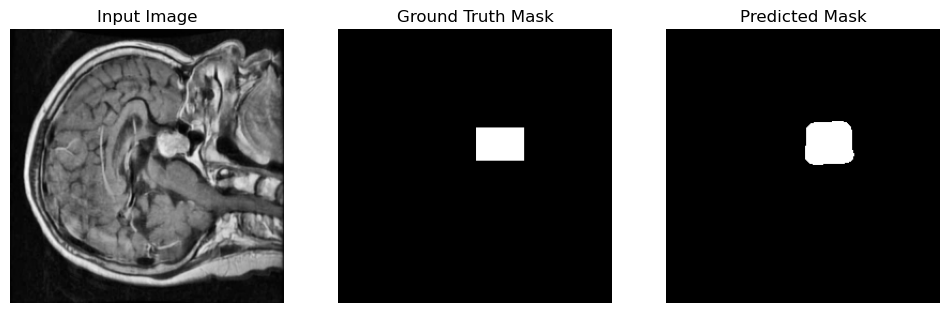

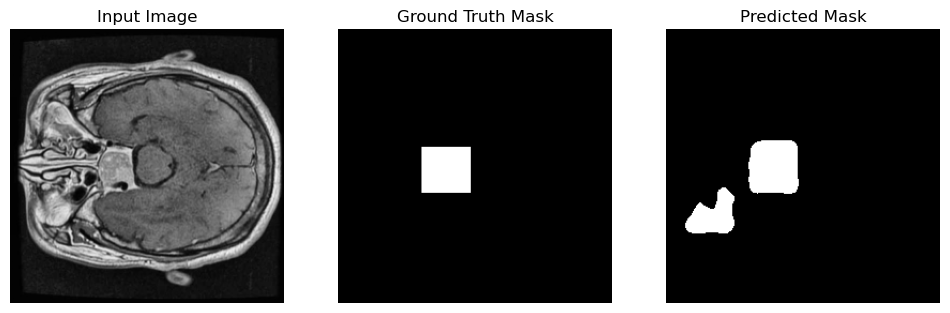

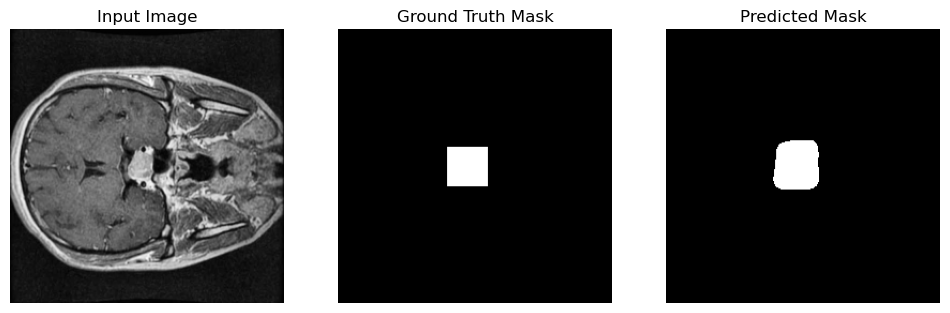

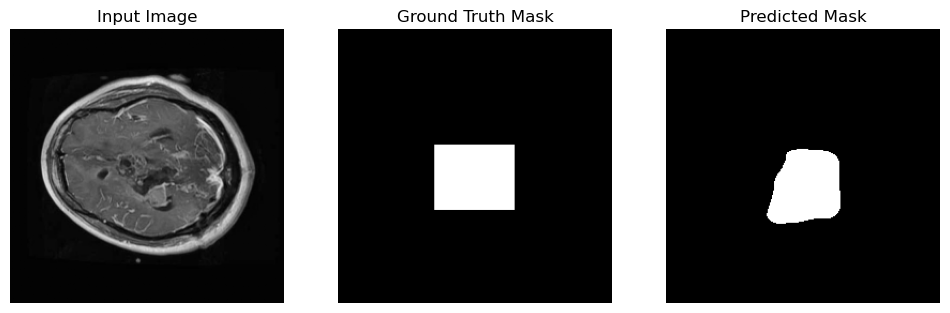

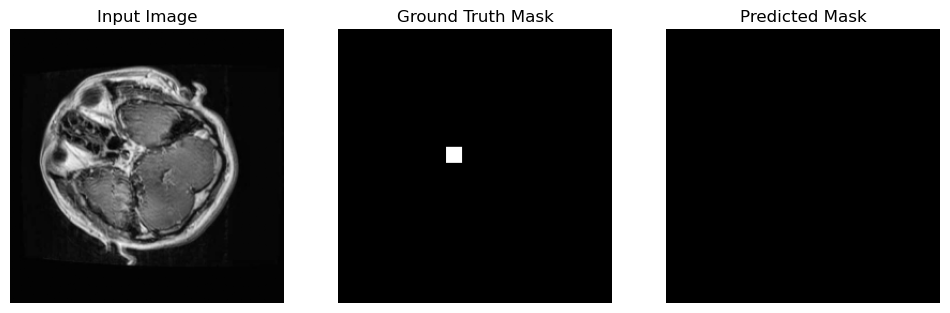

In [ ]:
print("\n--- Evaluating on Test Set ---")
model.load_state_dict(torch.load('best_model.pth'))

test_dataset = BrainTumorDataset(image_dir=TEST_IMG_DIR, json_path=TEST_JSON, transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_loss, test_dice = evaluate(model, test_loader, combined_loss, device)

print("\nTest Set Evaluation:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Dice Score: {test_dice:.4f}")
print("\nVisualizing some test predictions...")
visualize_predictions(model, test_loader, device, num_samples=5)

The Final Decision: The 1x1 Convolution
The last layer, OutConv, is the final judge. By the time the image is back to 224x224, the model has created 64 different detailed feature maps. The very last Conv2d layer (a 1x1 convolution) looks at each pixel location one by one.

For a single pixel at position (x, y), it looks at the 64 different feature values at that exact spot and makes a final decision. It has learned rules like:

"If the value for 'sharp-edge-feature' is high at this pixel, AND the value for 'smooth-texture-feature' is high, AND the value for 'circular-shape-feature' is high, then I am 95% confident this pixel is a tumor. Output a high value."

It does this for every single one of the 50,176 pixels (224 * 224), creating the final, precise mask.

# Evaluation on test
It was a success to build and train a U-Net-based semantic segmentation model to identify brain tumors in X-ray images. The model was optimized using a combination of Binary Cross-Entropy (BCE) and Dice loss functions, targeting both pixel-level accuracy and overall shape overlap. Upon final evaluation with a completely new set of test images, the model achieved a strong and reliable Test Dice Score of 0.7046, demonstrating its ability to generalize and identify tumor regions on unseen data with approximately 70.5% accuracy.

From the set of five test images, we observed that in the last image, the model failed to identify the tumor, while in the second image, although it correctly detected the main tumor area, it falsely identified an additional region as a tumor, where no tumor is actually present. On the bright side, it can identify both types of tumor (dark & bright).